# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Starbuck promotion strategy optimization

### Problem statement

   Starbuck provides offers to its mobile app registered customers in order to attract and retains its customer to improves its sales.Objective is to find out customers who are more likely to respond to their promotion based on the demographic details of the customer.To optimize the promotion strategy I put forward below 2 questions
   - Which are the demographic categories that have responded well to the offers, so that promotions can be designed considering the demographic features?
   - Which customers are more likely to respond to the offers? so that promotion can be done specific to those customers instead of launching for all customers.

### Load needed libraries

In [40]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import ast

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection  import train_test_split
from sklearn.metrics import classification_report ,precision_score,accuracy_score,recall_score
from sklearn.model_selection import GridSearchCV

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Analysis

Visualize the distribution of demographic feature to look for any outlier 
  For feature 'age' there are values near 120 which looks unrealistic 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbce2deb128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fbce2c70470>]], dtype=object)

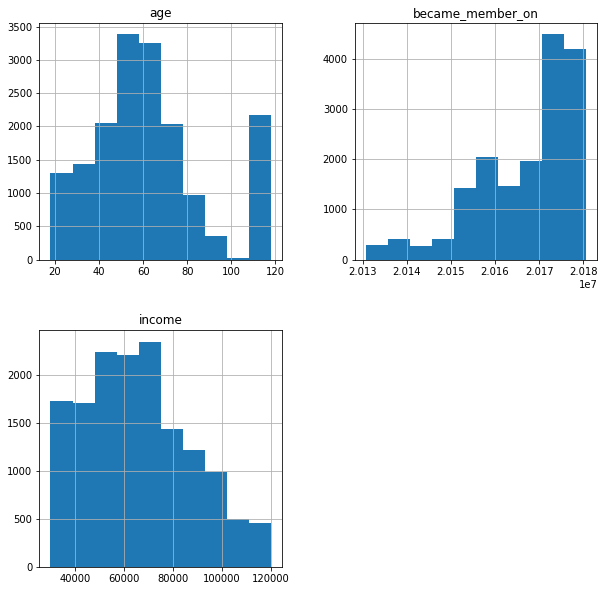

In [41]:
profile.hist(figsize=(10,10))

Check for the missing value in demographic feature , gender and income are having same number of missing values

In [42]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

### Preprocessing

New features are derived based on the available data for purpose of analysis

In [43]:
profile['became_member_on']=pd.to_datetime(profile.became_member_on ,format='%Y%m%d')
profile['Days_of_membership']=(profile['became_member_on'].max() - profile['became_member_on']  ).dt.days.astype('int16')
profile['New_member'] =profile['Days_of_membership'].apply(lambda x: 1 if x <60 else 0)
profile['Age_band'] =profile['age'].apply(lambda x: 'Yound' if x <=30 else ('Middle'  if (x>30 and x<=60) else 'Old' )   )
profile['high_income'] =profile['income'].apply(lambda x: 1 if x >65404 else 0)

In [44]:
profile.head(2)

,age,became_member_on,gender,id,income,Days_of_membership,New_member,Age_band,high_income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,0,Old,0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,Middle,1


In the transcript table offer id and amount for the transaction are available as text dictionary .Those are parsed and added back to dataframe

In [45]:
def f_dict_parse(i_dict):
    """
    input:
          dictionary in text
    Output:
           Value of parsed dictionary
    """
    o_value=list( i_dict.values()) [0] 
    return o_value


transcript.loc[transcript.event!='transaction' ,'offer_id']=transcript[transcript.event!='transaction']['value'].apply(f_dict_parse)
transcript.loc[transcript.event=='transaction' ,'amount']=transcript[transcript.event=='transaction']['value'].apply(f_dict_parse)

transcript['combined_id']=transcript['offer_id'] +"-"+ transcript["person"]

In [46]:
transcript.head(2)

,event,person,time,value,offer_id,amount,combined_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9-78afa995795e4...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7-a03223e636434...


For the purpose of analysis , summary dataframe has been derived below .This dataframe would have one entry for offer-person combination with details like whether offer has bee viewed/completed

In [47]:
# Create dataframe with unique offer-person combination


transcript_summary=pd.DataFrame( transcript[transcript.event!='transaction']['combined_id'].unique() ,columns=['combined_id'] )

df_wrk=pd.DataFrame( transcript[transcript.event=='offer completed']['combined_id'].unique() ,columns=['combined_id'] ) 
df_wrk['Complete_Indicator']=1

# Derive indicator variable for offer completion
transcript_summary['Complete_Indicator']=transcript_summary.join( df_wrk.set_index('combined_id')  , on='combined_id', lsuffix='_caller', rsuffix='_other'  )['Complete_Indicator']

# Drop the temprorary work dataframe
del df_wrk

# Derive indicator variable for offer viewing

df_wrk=pd.DataFrame( transcript[transcript.event=='offer viewed']['combined_id'].unique() ,columns=['combined_id'] ) 
df_wrk['Viewed_Indicator']=1

transcript_summary['Viewed_Indicator']=transcript_summary.join( df_wrk.set_index('combined_id')  , on='combined_id', lsuffix='_caller', rsuffix='_other'  )['Viewed_Indicator']

# Drop the temprorary work dataframe
del df_wrk

# Replace nan with zero for Complete_Indicator and Viewed_Indicator
transcript_summary['Complete_Indicator']=transcript_summary['Complete_Indicator'].apply(lambda x:0 if pd.isna(x) else 1)
transcript_summary['Viewed_Indicator']=transcript_summary['Viewed_Indicator'].apply(lambda x:0 if pd.isna(x) else 1)


transcript_summary[['offer_id','person']]=transcript_summary['combined_id'].str.split('-',expand=True)

# Add offer type and duration feature to summary dataframe 
transcript_summary[['offer_type','duration']]=transcript_summary.join(portfolio.set_index('id') ,on='offer_id')[['offer_type','duration']]


transcript_summary.head(2)

,combined_id,Complete_Indicator,Viewed_Indicator,offer_id,person,offer_type,duration
0,9b98b8c7a33c4b65b9aebfe6a799e6d9-78afa995795e4...,1,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,bogo,7
1,0b1e1539f2cc45b7b9fa7c272da2e1d7-a03223e636434...,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,discount,10


### Which are the demographic categories that have responded well to offers ?

From the summary of dataframe , success_rate of promotion has been derived at demograhic dimensions. I have excluded data with null value  in gender/income ,age>=100  as sufficient samples are  available even after exlusion.As the objective is to know the effect of promotion , details of persons who has not viewed the advertisment are excluded . Also combination of dimension with samples less than 50 are exclude as they are having less samples
   
    success_rate = no_of_completion/no_of_viewing

In [48]:
#  Handle the missing and bad data by droping those entries as there is sufficient data left even after exclusion 
df_derv=profile.join(transcript_summary.set_index('person') ,  on='id',how='inner'    ).query(" gender==gender & income==income & age <100 & Viewed_Indicator==1")\
[['New_member','Age_band','high_income','offer_type','Complete_Indicator','gender']]

# Group data at demographic dimension and derive the success_rate
df_derv_grp=df_derv.groupby(['New_member','Age_band','high_income','offer_type','gender'])['Complete_Indicator'].agg(['sum', 'count'])

df_derv_grp['Success_rate']=df_derv_grp['sum']/df_derv_grp['count']
print(' ')
print('Success rate of various demopgrahic combinations ordered as per success rate')
print(' ')
print('Note : Dimensions with sample size less than 50 are excluded  here ')
print(' ')

df_derv_grp.reset_index().sort_values(['Success_rate'] , ascending=False ).query(" count>=50 ").head(50)

 
Success rate of various demopgrahic combinations ordered as per success rate
 
Note : Dimensions with sample size less than 50 are excluded  here 
 


,New_member,Age_band,high_income,offer_type,gender,sum,count,Success_rate
30,0,Old,1,discount,F,1582,1831,0.864009
5,0,Middle,0,discount,O,57,67,0.850746
12,0,Middle,1,discount,F,1511,1796,0.841314
48,0,Yound,1,discount,F,59,71,0.830986
31,0,Old,1,discount,M,1186,1428,0.830532
3,0,Middle,0,discount,F,1071,1313,0.815689
39,0,Yound,0,discount,F,288,355,0.811268
27,0,Old,1,bogo,F,1661,2062,0.805529
9,0,Middle,1,bogo,F,1587,1991,0.797087
13,0,Middle,1,discount,M,1509,1896,0.795886


### Which customers are more likely to respond to the offers? so that promotion can be done specific to those customers instead of launching for all customers.

### Preprocessing of data to support training of classifier model

Dataframe has been derived to support the training of classifier model .Here instead of using New_member ,age/income band I will use the ordinal number as they holds more information for training the data model .

In [49]:
df=profile.join(transcript_summary.set_index('person') ,  on='id',how='inner'    ).query(" gender==gender & income==income & age <100 & Viewed_Indicator==1 & offer_type!='informational' ")\
[['combined_id','gender','age','Days_of_membership','offer_type','income','duration','Complete_Indicator']]
# [['New_member','Age_band','high_income','offer_type','Complete_Indicator','gender']]

df=df.reset_index(drop=True)

Onehotencoding and standardization of numeric value

In [50]:
df[['offer_type_bogo','gender_F','gender_O']] = pd.get_dummies(  df[['offer_type','gender']] )[['offer_type_bogo','gender_F','gender_O']]

scaler = StandardScaler()

df[['age','Days_of_membership','income','duration']] = scaler.fit_transform(df[['age','Days_of_membership','income','duration']] )


In [51]:
# list of feature for training the model

list_features=['offer_type_bogo','gender_F','gender_O','age','Days_of_membership','income']
df[list_features].head(2)


,offer_type_bogo,gender_F,gender_O,age,Days_of_membership,income
0,1,1,0,1.195061,-0.195277,1.606078
1,1,1,0,1.195061,-0.195277,1.606078


###  Train and predict the target

Train and test the classifier model .As the objective is to find out all potential customer who would respond to the promotion , recall is the metric used for the evaluation of the model.

In [52]:
clf=LogisticRegression()
parameters = [{'penalty':['l1','l2']}, {'C':[1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = clf,   param_grid = parameters,scoring = 'recall',cv = 5, verbose=0)


X_train, X_test, y_train, y_test =train_test_split(df[list_features] , df['Complete_Indicator'] , random_state=0 )
grid_search.fit(X_train,y_train)
y_hat=grid_search.predict(X_test)

###  Evaluation of the model based on recall

In [53]:
print( classification_report(y_test,y_hat) )

             precision    recall  f1-score   support

          0       0.62      0.34      0.44      2713
          1       0.75      0.90      0.82      5890

avg / total       0.71      0.73      0.70      8603



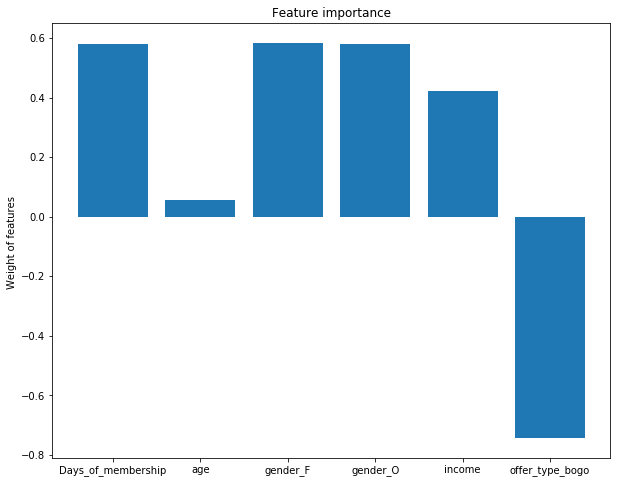

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

plt.bar(list_features, grid_search.best_estimator_.coef_[0] )
plt.ylabel("Weight of features ")
plt.title("Feature importance")
plt.show()